In [1]:
root_folder = '/ASTRA/'

In [2]:
import numpy as np
import os
import itertools
from skimage import io
import sys
import h5py
import glob
from skimage import io
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import pickle
import cv2

#### MODULES used in the code
sys.path.insert(0,root_folder+'ASTRA/modules/')
#from img_Sp_Sharp import create_img
from mask_roi_from_fiji import create_mask
from gen_single_astro import *#save_im,tune_th,spatial_pp
from sel_active_reg_gen import *

#SET IMAGES DIM
N = 256 
M = 256 

#SET Parameters
## dict active map extraction module
dict_param = {
    'list':[0,40,80,120,160],
    'blocks':15,
    'threads':32,
    'BPM_ratio':3,
    'bb':96,
    
    'N_pix_st':100, #starting minimum area
    'astr_min':80, # approx. 0.9 min in dataset
    'percentile': 80,
    'pad':5,
    'astro_num':4, # number of astro min in FOV
    'init_th_':0.6, # threshold initialization
    'decr_dim':10, # astro area decrease
    'decr_th':25, # temporal threshold decrease
    'corr_int':False, # intensity correction flag
    'gpu_flag':True
}


# Generate Masks from .zip 

In [3]:
folder_to_save = root_folder+'set1/dataset/'
mask_path_root = root_folder+'zip_mask/consensus/D1/'
if not(os.path.exists(folder_to_save)):
    os.mkdir(folder_to_save)
    print('Created',folder_to_save)

prefix='SMALL_'
folder_to_save+= prefix

In [4]:
remove_flag = True  # set true if you want to remove all
if remove_flag:
    for fl in glob.glob(folder_to_save+'*.hdf5'):
        os.remove(fl)
    for fl in glob.glob(folder_to_save+'*.tif'):
        os.remove(fl)

items = os.listdir(mask_path_root)#collect folder
items = [i for i in items if 'RoiSet' in i]

In [5]:
im_enh_l=[]

for item in items:        
        ######################################Mask#################################################
        mask_path = mask_path_root+item
        print('mask num: ',mask_path[-7:-4],' in ',mask_path)

        c_mask = create_mask(mask_path)###mask generation from .zip file generated using fiji
        instances_num = c_mask.get_dim()

        mask = np.empty((N, M, instances_num))
        soma_num, mask = c_mask.create_multiple_mask_im()#im_dim=None add this attribute 
        #if N,M are different from 256

        values_soma = np.zeros((N,M),dtype = np.float32 )

        values_soma = np.sum(mask[:,:,:soma_num],axis=2)
        values = np.sum(mask[:,:,soma_num:],axis=2)
        values[values>1]=1
        values = values.astype(np.float32) 
        values_soma = values_soma.astype(np.float32)
        
        #save unfiltered mask
        with h5py.File(folder_to_save +mask_path[-7:-4]+'_nf.hdf5','w') as f:
            dset = f.create_dataset('Values',data=values)
            dset2 = f.create_dataset('Values_soma',data=values_soma)
                

mask num:  009  in  /media/DATA/jbonato/astro_segm//zip_mask/consensus/D1/RoiSet_SMALL_009.zip
mask num:  003  in  /media/DATA/jbonato/astro_segm//zip_mask/consensus/D1/RoiSet_SMALL_003.zip
mask num:  011  in  /media/DATA/jbonato/astro_segm//zip_mask/consensus/D1/RoiSet_SMALL_011.zip
mask num:  006  in  /media/DATA/jbonato/astro_segm//zip_mask/consensus/D1/RoiSet_SMALL_006.zip
mask num:  014  in  /media/DATA/jbonato/astro_segm//zip_mask/consensus/D1/RoiSet_SMALL_014.zip
mask num:  015  in  /media/DATA/jbonato/astro_segm//zip_mask/consensus/D1/RoiSet_SMALL_015.zip
mask num:  016  in  /media/DATA/jbonato/astro_segm//zip_mask/consensus/D1/RoiSet_SMALL_016.zip
mask num:  004  in  /media/DATA/jbonato/astro_segm//zip_mask/consensus/D1/RoiSet_SMALL_004.zip
mask num:  008  in  /media/DATA/jbonato/astro_segm//zip_mask/consensus/D1/RoiSet_SMALL_008.zip
mask num:  010  in  /media/DATA/jbonato/astro_segm//zip_mask/consensus/D1/RoiSet_SMALL_010.zip
mask num:  021  in  /media/DATA/jbonato/astro_segm

# Get Somata Area

In [6]:
def measure_soma(soma,area_soma):
    ret, labels = cv2.connectedComponents(np.uint8(soma))
    for i in range(1,ret):
        pts = np.where(labels==i)
        area_soma.append(len(pts[0]))
    return ret-1

items = glob.glob(root_folder+'set1/dataset/*.hdf5')
#items = glob.glob('/media/DATA/jbonato/segm_project/mask_compl/*.hdf5')
hdf5_tot=[i for i in items if 'nf' in i]
res = np.empty((len(hdf5_tot),2))
hdf5_tot.sort()
hdf5_tot

area_soma = []

g=0
for i in hdf5_tot:
    print(i)
    area_soma_s = []
    dset= h5py.File(i,'r') 
    proc_mask =  np.asarray(dset['Values'])
    soma_mask =  np.asarray(dset['Values_soma'])
    proc_mask -= soma_mask
    proc_mask[proc_mask<0]=0
    g+= measure_soma(soma_mask,area_soma_s)
    area_soma.append(area_soma_s)


area_soma = list(itertools.chain.from_iterable(area_soma))
area_soma = np.asarray(area_soma)
print('There are {:d} somata'.format(g))
print('MIN {:d} and MAX {:d}'.format(area_soma.min(),area_soma.max()))
print(np.asarray([area_soma.max(),area_soma.min())

/media/DATA/jbonato/astro_segm/set1/dataset/SMALL_001_nf.hdf5
/media/DATA/jbonato/astro_segm/set1/dataset/SMALL_002_nf.hdf5
/media/DATA/jbonato/astro_segm/set1/dataset/SMALL_003_nf.hdf5
/media/DATA/jbonato/astro_segm/set1/dataset/SMALL_004_nf.hdf5
/media/DATA/jbonato/astro_segm/set1/dataset/SMALL_005_nf.hdf5
/media/DATA/jbonato/astro_segm/set1/dataset/SMALL_006_nf.hdf5
/media/DATA/jbonato/astro_segm/set1/dataset/SMALL_007_nf.hdf5
/media/DATA/jbonato/astro_segm/set1/dataset/SMALL_008_nf.hdf5
/media/DATA/jbonato/astro_segm/set1/dataset/SMALL_009_nf.hdf5
/media/DATA/jbonato/astro_segm/set1/dataset/SMALL_010_nf.hdf5
/media/DATA/jbonato/astro_segm/set1/dataset/SMALL_011_nf.hdf5
/media/DATA/jbonato/astro_segm/set1/dataset/SMALL_012_nf.hdf5
/media/DATA/jbonato/astro_segm/set1/dataset/SMALL_013_nf.hdf5
/media/DATA/jbonato/astro_segm/set1/dataset/SMALL_014_nf.hdf5
/media/DATA/jbonato/astro_segm/set1/dataset/SMALL_015_nf.hdf5
/media/DATA/jbonato/astro_segm/set1/dataset/SMALL_016_nf.hdf5
/media/D

In [12]:
dict_param['max_min'] = [345,89]

# Compute Thresholds in Local Activity filter

In [7]:
class tune_th(filt_im):
    
    def __init__(self, stack,mask,BB_dim,filt_meth='std'):
        self.BB_dim = BB_dim   
        self.stack = stack
        self.mask = mask
        self.coord_list,self.filt_im_zone = create_bb_coord(mask[:,:,1],BB_dim)
        self.filt_meth = filt_meth
        assert self.filt_meth =='std' or self.filt_meth =='std_par' or self.filt_meth=='ad_hoc','Undefined local activity filter'
    
    def save_im(self):
        dim = self.BB_dim
        T,N,M = self.stack.shape
        
        
        stack_to_crop = np.empty_like(self.stack)
        crop_stack = np.empty((T,dim,dim))
        crop_mask = np.empty((2,dim,dim))
        act_filt =np.zeros((N,M))
        
        TP_err=[]
        if self.filt_meth == 'std':
                for th1_p,th2_p in zip([0.3,0.25,0.20,0.15],[0.15,0.1,0.07,0.05]):
                    print('THRESH',th1_p,th2_p)
                    ##### to par
                    for coord in self.coord_list:
          
                        stack_to_crop = self.stack.copy()
                        crop_stack = stack_to_crop[:,coord[1]:coord[3],coord[0]:coord[2]]        
                        crop_mask_filt = self.filtering(crop_stack,th1_p,th2_p)
                        act_filt[coord[1]:coord[3],coord[0]:coord[2]] += crop_mask_filt
                    ##### to par
                    act_filt[act_filt>1]=1
                    soma_err = 100*np.sum(self.mask[:,:,1]-self.mask[:,:,1]*act_filt)/np.sum(self.mask[:,:,1])
                    proc_err = 100*np.sum(self.mask[:,:,0]-self.mask[:,:,0]*act_filt)/np.sum(self.mask[:,:,0])
                    TP_err.append(np.asarray([soma_err,proc_err]))
        
        elif self.filt_meth == 'std_par':
            self.im_enh = np.ones((N,M))
            pad=0 
            out_dim = self.BB_dim + 2*pad
            for th1_p,th2_p in zip([0.3,0.25,0.20,0.15],[0.15,0.1,0.07,0.05]):
                print('THRESH',th1_p,th2_p)
                ##### to par
                act_filt =np.zeros((N,M))

                list_out = Parallel(n_jobs=-1,verbose=1,require='sharedmem')(delayed(self.gen_single_im)(self.stack[:,self.coord_list[i][1]:self.coord_list[i][3],self.coord_list[i][0]:self.coord_list[i][2]],self.im_enh[self.coord_list[i][1]:self.coord_list[i][3],self.coord_list[i][0]:self.coord_list[i][2]],i,pad,th1_p,th2_p) for i in range(len(self.coord_list)))
                ###recompose
                ###
                for res in list_out:
                    idx = res[1]
                    act_filt[self.coord_list[idx][1]:self.coord_list[idx][3],self.coord_list[idx][0]:self.coord_list[idx][2]] += res[0][1,pad:out_dim-pad,pad:out_dim-pad]

                act_filt[act_filt>1]=1
                soma_err = 100*np.sum(self.mask[:,:,1]-self.mask[:,:,1]*act_filt)/np.sum(self.mask[:,:,1])
                proc_err = 100*np.sum(self.mask[:,:,0]-self.mask[:,:,0]*act_filt)/np.sum(self.mask[:,:,0])
                TP_err.append(np.asarray([soma_err,proc_err]))  

        
        elif self.filt_meth == 'ad_hoc':
                for th1_p in [0.3,0.25,0.20,0.15]:
                    
                    for coord in self.coord_list:
                        stack_to_crop = self.stack.copy()
                        crop_stack = stack_to_crop[:,coord[1]:coord[3],coord[0]:coord[2]]        
                        crop_mask_filt = self.filtering_hoc(crop_stack,th1_p)
                        act_filt[coord[1]:coord[3],coord[0]:coord[2]] += crop_mask_filt
                        
                    act_filt[act_filt>1]=1
                    TP_err.append(100*np.sum(self.mask-self.mask*act_filt)/np.sum(self.mask))
       
        TP_err = np.asarray(TP_err)
        return TP_err

In [8]:
path = root_folder+'set1/'
res = np.empty((4,2,24))
fov = 0
import time
it = time.time()
for j in range(1,26):
    if j !=20:
        
        if len(str(j))==1:
            test_folder_str='00'+str(j)
        else:
            test_folder_str='0'+str(j)
        
        path_f = path+str(j)+'/'
        item = glob.glob(path_f+'*')
        print(path_f,item)
 
        sp_pp=spatial_pp(item[0])
        stack,_ = sp_pp.create_img()
        ### use functions in spatia_pp for the generation of corrected stack
        ### for dataset2 and dataset3
        T,N,_ = stack.shape
        
        Res_file_path=root_folder+'set1/dataset/SMALL_'+test_folder_str+'_nf.hdf5'
        Res_mat = np.empty((N,N,2))
        dset= h5py.File(Res_file_path,'r') 
        Res_mat[:,:,0] =  np.asarray(dset['Values'])
        Res_mat[:,:,1] =  np.asarray(dset['Values_soma'])

        
        th_res = tune_th(stack,mask=Res_mat,BB_dim=86,filt_meth='std_par')
        thre = th_res.save_im()
        
        if j>20:
            res[:,:,j-2] = thre
        else:
            res[:,:,j-1] = thre
    print(time.time()-it)


/media/DATA/jbonato/astro_segm/set1/1/ ['/media/DATA/jbonato/astro_segm/set1/1/TSeries-04082019-1513-1250_Ch2__movie_corrected_aligned.tiff']
file loading...
THRESH 0.3 0.15


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


THRESH 0.25 0.1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


THRESH 0.2 0.07


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


THRESH 0.15 0.05


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


3.0906803607940674
/media/DATA/jbonato/astro_segm/set1/2/ ['/media/DATA/jbonato/astro_segm/set1/2/TSeries-04082019-1513-1251_Ch2__movie_corrected_aligned.tiff']
file loading...
THRESH 0.3 0.15


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


THRESH 0.25 0.1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


THRESH 0.2 0.07


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


THRESH 0.15 0.05


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


5.716641664505005
/media/DATA/jbonato/astro_segm/set1/3/ ['/media/DATA/jbonato/astro_segm/set1/3/TSeries-04082019-1513-1252_Ch2__movie_corrected_aligned.tiff']
file loading...
THRESH 0.3 0.15


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


THRESH 0.25 0.1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


THRESH 0.2 0.07


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


THRESH 0.15 0.05


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


8.747846603393555
/media/DATA/jbonato/astro_segm/set1/4/ ['/media/DATA/jbonato/astro_segm/set1/4/TSeries-04112019-1605-1257_Ch2__movie_corrected_aligned.tiff']
file loading...
THRESH 0.3 0.15


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.2s finished


THRESH 0.25 0.1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.2s finished


THRESH 0.2 0.07


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.2s finished


THRESH 0.15 0.05


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.2s finished


11.813123226165771
/media/DATA/jbonato/astro_segm/set1/5/ ['/media/DATA/jbonato/astro_segm/set1/5/TSeries-04112019-1605-1258_Ch2__movie_corrected_aligned.tiff']
file loading...
THRESH 0.3 0.15


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


THRESH 0.25 0.1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished


THRESH 0.2 0.07


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


THRESH 0.15 0.05


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


14.227691650390625
/media/DATA/jbonato/astro_segm/set1/6/ ['/media/DATA/jbonato/astro_segm/set1/6/TSeries-04112019-1605-1266_Ch2__movie_corrected_aligned.tiff']
file loading...
THRESH 0.3 0.15


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished


THRESH 0.25 0.1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished


THRESH 0.2 0.07


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished


THRESH 0.15 0.05


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished


17.367876291275024
/media/DATA/jbonato/astro_segm/set1/7/ ['/media/DATA/jbonato/astro_segm/set1/7/TSeries-04112019-1605-1267_Ch2__movie_corrected_aligned.tiff']
file loading...
THRESH 0.3 0.15


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.2s finished


THRESH 0.25 0.1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.2s finished


THRESH 0.2 0.07


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.2s finished


THRESH 0.15 0.05


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.2s finished


20.465258836746216
/media/DATA/jbonato/astro_segm/set1/8/ ['/media/DATA/jbonato/astro_segm/set1/8/TSeries-04112019-1605-1268_Ch2__movie_corrected_aligned.tiff']
file loading...
THRESH 0.3 0.15


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.2s finished


THRESH 0.25 0.1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.2s finished


THRESH 0.2 0.07


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.2s finished


THRESH 0.15 0.05


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.2s finished


23.08000087738037
/media/DATA/jbonato/astro_segm/set1/9/ ['/media/DATA/jbonato/astro_segm/set1/9/TSeries-04172019-1817-1280_Ch2__movie_corrected_aligned.tiff']
file loading...
THRESH 0.3 0.15


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s finished


THRESH 0.25 0.1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s finished


THRESH 0.2 0.07


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s finished


THRESH 0.15 0.05


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s finished


26.12685227394104
/media/DATA/jbonato/astro_segm/set1/10/ ['/media/DATA/jbonato/astro_segm/set1/10/TSeries-04172019-1817-1281_Ch2__movie_corrected_aligned.tiff']
file loading...
THRESH 0.3 0.15


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.2s finished


THRESH 0.25 0.1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.2s finished


THRESH 0.2 0.07


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.2s finished


THRESH 0.15 0.05


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.2s finished


29.17803931236267
/media/DATA/jbonato/astro_segm/set1/11/ ['/media/DATA/jbonato/astro_segm/set1/11/TSeries-04172019-1817-1282_Ch2__movie_corrected_aligned.tiff']
file loading...
THRESH 0.3 0.15


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.2s finished


THRESH 0.25 0.1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.2s finished


THRESH 0.2 0.07


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.2s finished


THRESH 0.15 0.05


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.2s finished


32.240954875946045
/media/DATA/jbonato/astro_segm/set1/12/ ['/media/DATA/jbonato/astro_segm/set1/12/TSeries-04172019-1817-1287_Ch2__movie_corrected_aligned.tiff']
file loading...
THRESH 0.3 0.15


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


THRESH 0.25 0.1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


THRESH 0.2 0.07


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


THRESH 0.15 0.05


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


35.29541373252869
/media/DATA/jbonato/astro_segm/set1/13/ ['/media/DATA/jbonato/astro_segm/set1/13/TSeries-04172019-1817-1288_Ch2__movie_corrected_aligned.tiff']
file loading...
THRESH 0.3 0.15


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s finished


THRESH 0.25 0.1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s finished


THRESH 0.2 0.07


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s finished


THRESH 0.15 0.05


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s finished


38.44892382621765
/media/DATA/jbonato/astro_segm/set1/14/ ['/media/DATA/jbonato/astro_segm/set1/14/TSeries-04172019-1817-1289_Ch2__movie_corrected_aligned.tiff']
file loading...
THRESH 0.3 0.15


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s finished


THRESH 0.25 0.1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s finished


THRESH 0.2 0.07


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s finished


THRESH 0.15 0.05


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished


40.91057252883911
/media/DATA/jbonato/astro_segm/set1/15/ ['/media/DATA/jbonato/astro_segm/set1/15/TSeries-04182019-1453-1295_Ch2__movie_corrected_aligned.tiff']
file loading...
THRESH 0.3 0.15


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


THRESH 0.25 0.1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


THRESH 0.2 0.07


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


THRESH 0.15 0.05


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


43.39076471328735
/media/DATA/jbonato/astro_segm/set1/16/ ['/media/DATA/jbonato/astro_segm/set1/16/TSeries-06072018-1654-1094_Ch2__movie_corrected_aligned.tiff']
file loading...
THRESH 0.3 0.15


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.2s finished


THRESH 0.25 0.1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.2s finished


THRESH 0.2 0.07


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.2s finished


THRESH 0.15 0.05
46.38871908187866
/media/DATA/jbonato/astro_segm/set1/17/ ['/media/DATA/jbonato/astro_segm/set1/17/TSeries-07192018-1913-1119_Ch2__movie_corrected_aligned.tiff']
file loading...
THRESH 0.3 0.15


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


THRESH 0.25 0.1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


THRESH 0.2 0.07


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


THRESH 0.15 0.05


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


49.78945970535278
/media/DATA/jbonato/astro_segm/set1/18/ ['/media/DATA/jbonato/astro_segm/set1/18/TSeries-07262018-1151-1126_Ch2__movie_corrected_aligned.tiff']
file loading...
THRESH 0.3 0.15


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.2s finished


THRESH 0.25 0.1


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.


THRESH 0.2 0.07


[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.


THRESH 0.15 0.05


[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.2s finished


53.86810111999512
/media/DATA/jbonato/astro_segm/set1/19/ ['/media/DATA/jbonato/astro_segm/set1/19/TSeries-07262018-1151-1129_Ch2__movie_corrected_aligned.tiff']
file loading...
THRESH 0.3 0.15


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.


THRESH 0.25 0.1


[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    0.2s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.


THRESH 0.2 0.07


[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.


THRESH 0.15 0.05


[Parallel(n_jobs=-1)]: Done   2 out of   6 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.2s finished


57.657697677612305
57.65779948234558
/media/DATA/jbonato/astro_segm/set1/21/ ['/media/DATA/jbonato/astro_segm/set1/21/TSeries-09042017-1020-547_Cycle00001_Ch2_0000movieNoRM4Iteration.tif']
file loading...
THRESH 0.3 0.15


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.


THRESH 0.25 0.1


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.


THRESH 0.2 0.07


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.


THRESH 0.15 0.05


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


62.351110219955444
/media/DATA/jbonato/astro_segm/set1/22/ ['/media/DATA/jbonato/astro_segm/set1/22/TSeries-09042017-1020-551_Cycle00001_Ch2_0000movieNoRM4Iteration.tif']
file loading...
THRESH 0.3 0.15


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.


THRESH 0.25 0.1


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.


THRESH 0.2 0.07


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.


THRESH 0.15 0.05


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished


67.0223593711853
/media/DATA/jbonato/astro_segm/set1/23/ ['/media/DATA/jbonato/astro_segm/set1/23/TSeries-09052017-1126-559_Cycle00001_Ch2_0000movieNoRM4Iteration.tif']
file loading...
THRESH 0.3 0.15


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.


THRESH 0.25 0.1


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.


THRESH 0.2 0.07


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.


THRESH 0.15 0.05


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.2s finished


71.71507430076599
/media/DATA/jbonato/astro_segm/set1/24/ ['/media/DATA/jbonato/astro_segm/set1/24/TSeries-09052017-1126-564_Cycle00001_Ch2_0000movieNoRM4Iteration.tif']
file loading...
THRESH 0.3 0.15


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.


THRESH 0.25 0.1


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.


THRESH 0.2 0.07


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.


THRESH 0.15 0.05


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


76.43515920639038
/media/DATA/jbonato/astro_segm/set1/25/ ['/media/DATA/jbonato/astro_segm/set1/25/TSeries-09052017-1126-572_Cycle00001_Ch2_0000movie_momovieNoRM4Iteration.tif']
file loading...
THRESH 0.3 0.15


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.


THRESH 0.25 0.1


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.


THRESH 0.2 0.07


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.


THRESH 0.15 0.05
81.00184869766235


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


(4, 2)


Text(0.5, 1.0, 'Processes')

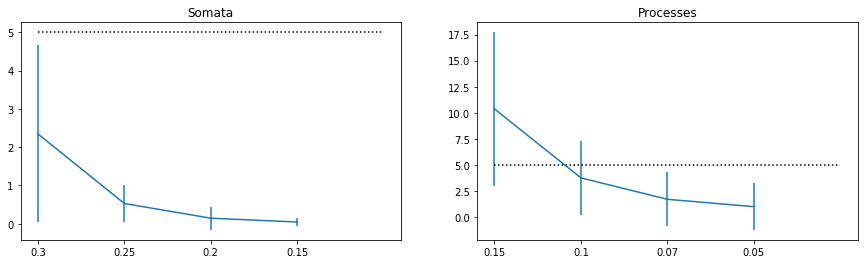

In [9]:
vec = np.mean(res,axis=2)
err = np.std(res,axis=2)
print(vec.shape)
fig,[ax1,ax2] = plt.subplots(figsize=(15,4),ncols=2,nrows=1)
ax1.errorbar(np.arange(4),vec[:,0],yerr=err[:,0])
ax2.errorbar(np.arange(4),vec[:,1],yerr=err[:,1])
ax1.set_xticks(np.arange(4))
ax2.set_xticks(np.arange(4))
ax1.set_xticklabels([0.3,0.25,0.20,0.15])
ax2.set_xticklabels([0.15,0.1,0.07,0.05])
ax1.hlines(xmin=0,xmax=4,y=5,linestyles='dotted')
ax2.hlines(xmin=0,xmax=4,y=5,linestyles='dotted')
ax1.set_title('Somata')
ax2.set_title('Processes')


In [3]:
dict_param['th1_p']=0.25
dict_param['th2_p']=0.1

# Activity Map Generator: Set percentile

In [11]:
path = root_folder+'set1/'
res = np.empty((24,7))
fov = 0
resize=False
it = time.time()
for j in range(1,26):
    if j !=20:
        
        if len(str(j))==1:
            test_folder_str='00'+str(j)
        else:
            test_folder_str='0'+str(j)
        
        path_f = path+str(j)+'/'
        item = glob.glob(path_f+'*')
        print(path_f,item)
        
        #for dataset2 and dataset3 this class is necessary to transform the stack
        #sp_pp=spatial_pp(item[0])
        #stack,_ = sp_pp.create_img()

        stack = io.imread(item[0])
        T,N,_ = stack.shape

        Res_file_path=root_folder+'set1/dataset/SMALL_'+test_folder_str+'_nf.hdf5'
        Res_mat = np.empty((N,N,2))
        dset= h5py.File(Res_file_path,'r') 
        Res_mat[:,:,0] =  np.asarray(dset['Values'])
        Res_mat[:,:,1] =  np.asarray(dset['Values_soma'])


        maskGT = np.sum(Res_mat,axis=2)
        maskGT[maskGT>1]=1
        iter_ = 0
        for i in [30,40,50,60,70,80,90]:
            
            dict_param['percentile'] = i 
            
            cr = sel_active_reg(stack,dict_param,verbose=False)
            ##
            mask = cr.get_mask(long_rec=False)
            res[fov,iter_] = f1_score(maskGT.flatten(), mask.flatten(), average='binary')
            iter_+=1
        fov+=1
        print(time.time()-it)

/media/DATA/jbonato/astro_segm/set1/1/ ['/media/DATA/jbonato/astro_segm/set1/1/TSeries-04082019-1513-1250_Ch2__movie_corrected_aligned.tiff']
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    1.4s finished


NUM CComponents 71
Found iter 2
Found iter 2
NUM CComponents 69
Found iter 2
Found iter 2
NUM CComponents 49
Found iter 1
Found iter 1
NUM CComponents 26
Found iter 1
Found iter 1
NUM CComponents 18
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 171
Found iter 3
Found iter 3
NUM CComponents 116
Found iter 2
Found iter 3
NUM CComponents 91
Found iter 2
Found iter 3
NUM CComponents 77
Found iter 2
Found iter 2
NUM CComponents 66
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 3
Found iter 3
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 268
Found iter 14
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.4s finished


NUM CComponents 361
Found iter 22
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 351
Found iter 18
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.4s finished


NUM CComponents 291
Found iter 9
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 162
Found iter 4
10.556501865386963
/media/DATA/jbonato/astro_segm/set1/2/ ['/media/DATA/jbonato/astro_segm/set1/2/TSeries-04082019-1513-1251_Ch2__movie_corrected_aligned.tiff']
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 87
Found iter 2
Found iter 2
NUM CComponents 72
Found iter 2
Found iter 2
NUM CComponents 46
Found iter 1
Found iter 2
NUM CComponents 30
Found iter 1
Found iter 1
NUM CComponents 30
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.4s finished


NUM CComponents 165
Found iter 8
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 270
Found iter 16
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 313
Found iter 14
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 317
Found iter 13
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.4s finished


NUM CComponents 268
Found iter 12
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.4s finished


NUM CComponents 147
Found iter 4
18.83776092529297
/media/DATA/jbonato/astro_segm/set1/3/ ['/media/DATA/jbonato/astro_segm/set1/3/TSeries-04082019-1513-1252_Ch2__movie_corrected_aligned.tiff']
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 108
Found iter 2
Found iter 2
NUM CComponents 61
Found iter 3
Found iter 3
NUM CComponents 44
Found iter 2
Found iter 2
NUM CComponents 28
Found iter 1
Found iter 1
NUM CComponents 24
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 2
Found iter 2
Found iter 2
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 211
Found iter 5
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 251
Found iter 12
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 306
Found iter 18
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 332
Found iter 12
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 245
Found iter 6
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 140
Found iter 5
26.775254487991333
/media/DATA/jbonato/astro_segm/set1/4/ ['/media/DATA/jbonato/astro_segm/set1/4/TSeries-04112019-1605-1257_Ch2__movie_corrected_aligned.tiff']
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 64
Found iter 3
Found iter 3
NUM CComponents 48
Found iter 2
Found iter 2
NUM CComponents 53
Found iter 1
Found iter 1
NUM CComponents 52
Found iter 1
Found iter 1
NUM CComponents 58
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 2
Found iter 2
Found iter 2
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 74
Found iter 4
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 135
Found iter 5
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 127
Found iter 16
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 152
Found iter 14
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 107
Found iter 8
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 40
Found iter 5
34.45720720291138
/media/DATA/jbonato/astro_segm/set1/5/ ['/media/DATA/jbonato/astro_segm/set1/5/TSeries-04112019-1605-1258_Ch2__movie_corrected_aligned.tiff']
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 76
Found iter 4
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 98
Found iter 5
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 109
Found iter 7
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 148
Found iter 10
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 129
Found iter 11
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 88
Found iter 9
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.4s finished


NUM CComponents 39
Found iter 5
41.81721782684326
/media/DATA/jbonato/astro_segm/set1/6/ ['/media/DATA/jbonato/astro_segm/set1/6/TSeries-04112019-1605-1266_Ch2__movie_corrected_aligned.tiff']
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 73
Found iter 3
Found iter 3
NUM CComponents 64
Found iter 2
Found iter 3
NUM CComponents 36
Found iter 1
Found iter 1
NUM CComponents 19
Found iter 1
Found iter 1
NUM CComponents 8
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 119
Found iter 4
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 197
Found iter 12
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 212
Found iter 15
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 203
Found iter 9
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 144
Found iter 10
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 98
Found iter 5
49.48875617980957
/media/DATA/jbonato/astro_segm/set1/7/ ['/media/DATA/jbonato/astro_segm/set1/7/TSeries-04112019-1605-1267_Ch2__movie_corrected_aligned.tiff']
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.4s finished


NUM CComponents 126
Found iter 3
Found iter 5
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 175
Found iter 4
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 240
Found iter 10
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 280
Found iter 8
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 249
Found iter 13
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 206
Found iter 12
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 114
Found iter 7
57.2668137550354
/media/DATA/jbonato/astro_segm/set1/8/ ['/media/DATA/jbonato/astro_segm/set1/8/TSeries-04112019-1605-1268_Ch2__movie_corrected_aligned.tiff']
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 96
Found iter 2
Found iter 2
NUM CComponents 74
Found iter 2
Found iter 2
NUM CComponents 60
Found iter 2
Found iter 2
NUM CComponents 38
Found iter 2
Found iter 2
NUM CComponents 26
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 167
Found iter 3
Found iter 5
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 215
Found iter 8
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 229
Found iter 12
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 277
Found iter 14
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 189
Found iter 9
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 111
Found iter 11
65.22592544555664
/media/DATA/jbonato/astro_segm/set1/9/ ['/media/DATA/jbonato/astro_segm/set1/9/TSeries-04172019-1817-1280_Ch2__movie_corrected_aligned.tiff']
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 71
Found iter 4
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 137
Found iter 5
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 229
Found iter 11
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 342
Found iter 15
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 343
Found iter 15
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 258
Found iter 10
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 143
Found iter 5
72.91346836090088
/media/DATA/jbonato/astro_segm/set1/10/ ['/media/DATA/jbonato/astro_segm/set1/10/TSeries-04172019-1817-1281_Ch2__movie_corrected_aligned.tiff']
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 48
Found iter 2
Found iter 2
NUM CComponents 30
Found iter 1
Found iter 1
NUM CComponents 15
Found iter 1
Found iter 1
NUM CComponents 17
Found iter 1
Found iter 1
NUM CComponents 7
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.4s finished


NUM CComponents 169
Found iter 8
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 252
Found iter 14
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 280
Found iter 18
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 259
Found iter 14
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 172
Found iter 7
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 73
Found iter 5
80.64610862731934
/media/DATA/jbonato/astro_segm/set1/11/ ['/media/DATA/jbonato/astro_segm/set1/11/TSeries-04172019-1817-1282_Ch2__movie_corrected_aligned.tiff']
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 98
Found iter 2
Found iter 2
NUM CComponents 70
Found iter 2
Found iter 2
NUM CComponents 62
Found iter 1
Found iter 1
NUM CComponents 33
Found iter 1
Found iter 1
NUM CComponents 28
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 2
Found iter 2
Found iter 2
Found iter 4
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.4s finished


NUM CComponents 222
Found iter 8
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.4s finished


NUM CComponents 308
Found iter 16
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.4s finished


NUM CComponents 325
Found iter 17
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 346
Found iter 17
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.4s finished


NUM CComponents 311
Found iter 14
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.4s finished


NUM CComponents 169
Found iter 4
89.0249228477478
/media/DATA/jbonato/astro_segm/set1/12/ ['/media/DATA/jbonato/astro_segm/set1/12/TSeries-04172019-1817-1287_Ch2__movie_corrected_aligned.tiff']
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.4s finished


NUM CComponents 93
Found iter 2
Found iter 2
NUM CComponents 86
Found iter 2
Found iter 2
NUM CComponents 72
Found iter 2
Found iter 3
NUM CComponents 62
Found iter 3
Found iter 3
NUM CComponents 50
Found iter 2
Found iter 2
Found iter 2
Found iter 2
Found iter 2
Found iter 2
Found iter 3
Found iter 4
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 142
Found iter 4
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 173
Found iter 8
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 195
Found iter 10
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 205
Found iter 14
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 196
Found iter 11
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 102
Found iter 4
97.14090371131897
/media/DATA/jbonato/astro_segm/set1/13/ ['/media/DATA/jbonato/astro_segm/set1/13/TSeries-04172019-1817-1288_Ch2__movie_corrected_aligned.tiff']
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 70
Found iter 3
Found iter 3
NUM CComponents 48
Found iter 2
Found iter 2
NUM CComponents 36
Found iter 1
Found iter 1
NUM CComponents 31
Found iter 1
Found iter 1
NUM CComponents 30
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 2
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 154
Found iter 6
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 207
Found iter 14
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.4s finished


NUM CComponents 259
Found iter 16
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 279
Found iter 16
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 236
Found iter 9
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 119
Found iter 3
Found iter 3
NUM CComponents 139
Found iter 3
Found iter 4
105.27473616600037
/media/DATA/jbonato/astro_segm/set1/14/ ['/media/DATA/jbonato/astro_segm/set1/14/TSeries-04172019-1817-1289_Ch2__movie_corrected_aligned.tiff']
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.4s finished


NUM CComponents 111
Found iter 4
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 181
Found iter 4
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 241
Found iter 9
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 266
Found iter 14
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 295
Found iter 12
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 231
Found iter 8
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 138
Found iter 5
112.98489212989807
/media/DATA/jbonato/astro_segm/set1/15/ ['/media/DATA/jbonato/astro_segm/set1/15/TSeries-04182019-1453-1295_Ch2__movie_corrected_aligned.tiff']
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 85
Found iter 2
Found iter 2
NUM CComponents 40
Found iter 1
Found iter 1
NUM CComponents 24
Found iter 1
Found iter 1
NUM CComponents 15
Found iter 1
Found iter 1
NUM CComponents 7
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 176
Found iter 7
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.6s finished


NUM CComponents 222
Found iter 16
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.4s finished


NUM CComponents 218
Found iter 15
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 167
Found iter 10
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.4s finished


NUM CComponents 108
Found iter 5
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 550 out of 550 | elapsed:    0.3s finished


NUM CComponents 46
Found iter 3
Found iter 3
NUM CComponents 57
Found iter 3
Found iter 3
NUM CComponents 75
Found iter 3
Found iter 3
NUM CComponents 87
Found iter 5
120.98824381828308
/media/DATA/jbonato/astro_segm/set1/16/ ['/media/DATA/jbonato/astro_segm/set1/16/TSeries-06072018-1654-1094_Ch2__movie_corrected_aligned.tiff']
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 54
Found iter 1
Found iter 1
NUM CComponents 54
Found iter 1
Found iter 1
NUM CComponents 39
Found iter 1
Found iter 1
NUM CComponents 37
Found iter 1
Found iter 1
NUM CComponents 32
Found iter 1
Found iter 1
NUM CComponents 23
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 89
Found iter 7
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 117
Found iter 9
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 161
Found iter 16
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 197
Found iter 23
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 197
Found iter 14
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.6s finished


NUM CComponents 113
Found iter 6
130.96919679641724
/media/DATA/jbonato/astro_segm/set1/17/ ['/media/DATA/jbonato/astro_segm/set1/17/TSeries-07192018-1913-1119_Ch2__movie_corrected_aligned.tiff']
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.5s finished


NUM CComponents 61
Found iter 4
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 87
Found iter 7
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.6s finished


NUM CComponents 113
Found iter 11
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 111
Found iter 11
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 92
Found iter 14
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.5s finished


NUM CComponents 74
Found iter 11
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 42
Found iter 4
140.79434728622437
/media/DATA/jbonato/astro_segm/set1/18/ ['/media/DATA/jbonato/astro_segm/set1/18/TSeries-07262018-1151-1126_Ch2__movie_corrected_aligned.tiff']
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 16
Found iter 1
Found iter 1
NUM CComponents 20
Found iter 1
Found iter 1
NUM CComponents 17
Found iter 1
Found iter 1
NUM CComponents 17
Found iter 1
Found iter 1
NUM CComponents 15
Found iter 1
Found iter 1
NUM CComponents 12
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 40
Found iter 6
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 114
Found iter 12
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 180
Found iter 16
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 237
Found iter 21
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 212
Found iter 14
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 108
Found iter 5
150.34338307380676
/media/DATA/jbonato/astro_segm/set1/19/ ['/media/DATA/jbonato/astro_segm/set1/19/TSeries-07262018-1151-1129_Ch2__movie_corrected_aligned.tiff']
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.6s finished


NUM CComponents 40
Found iter 1
Found iter 1
NUM CComponents 38
Found iter 1
Found iter 1
NUM CComponents 30
Found iter 1
Found iter 1
NUM CComponents 26
Found iter 1
Found iter 1
NUM CComponents 27
Found iter 1
Found iter 1
NUM CComponents 28
Found iter 2
Found iter 3
Found iter 3
Found iter 3
Found iter 3
Found iter 3
Found iter 3
Found iter 3
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.5s finished


NUM CComponents 59
Found iter 5
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.5s finished


NUM CComponents 99
Found iter 10
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 138
Found iter 15
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 160
Found iter 18
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.6s finished


NUM CComponents 123
Found iter 14
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 80
Found iter 8
160.83090662956238
/media/DATA/jbonato/astro_segm/set1/21/ ['/media/DATA/jbonato/astro_segm/set1/21/TSeries-09042017-1020-547_Cycle00001_Ch2_0000movieNoRM4Iteration.tif']
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 95
Found iter 1
Found iter 1
NUM CComponents 62
Found iter 1
Found iter 1
NUM CComponents 43
Found iter 1
Found iter 1
NUM CComponents 39
Found iter 1
Found iter 1
NUM CComponents 35
Found iter 1
Found iter 1
NUM CComponents 24
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.6s finished


NUM CComponents 216
Found iter 3
Found iter 5
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 238
Found iter 10
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 243
Found iter 15
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 239
Found iter 12
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 154
Found iter 9
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.6s finished


NUM CComponents 82
Found iter 6
171.23371195793152
/media/DATA/jbonato/astro_segm/set1/22/ ['/media/DATA/jbonato/astro_segm/set1/22/TSeries-09042017-1020-551_Cycle00001_Ch2_0000movieNoRM4Iteration.tif']
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 147
Found iter 1
Found iter 1
NUM CComponents 106
Found iter 1
Found iter 1
NUM CComponents 76
Found iter 1
Found iter 1
NUM CComponents 50
Found iter 1
Found iter 1
NUM CComponents 18
Found iter 1
Found iter 1
NUM CComponents 18
Found iter 1
Found iter 1
Found iter 1
Found iter 2
Found iter 2
Found iter 2
Found iter 2
Found iter 2
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 184
Found iter 13
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.6s finished


NUM CComponents 173
Found iter 11
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 171
Found iter 12
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 142
Found iter 9
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 109
Found iter 7
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 76
Found iter 4
181.36836576461792
/media/DATA/jbonato/astro_segm/set1/23/ ['/media/DATA/jbonato/astro_segm/set1/23/TSeries-09052017-1126-559_Cycle00001_Ch2_0000movieNoRM4Iteration.tif']
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 137
Found iter 1
Found iter 1
NUM CComponents 65
Found iter 1
Found iter 1
NUM CComponents 45
Found iter 1
Found iter 1
NUM CComponents 20
Found iter 1
Found iter 1
NUM CComponents 12
Found iter 1
Found iter 1
NUM CComponents 10
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 355
Found iter 9
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.6s finished


NUM CComponents 186
Found iter 9
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 104
Found iter 7
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 69
Found iter 3
Found iter 3
NUM CComponents 76
Found iter 3
Found iter 3
NUM CComponents 90
Found iter 5
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.5s finished


NUM CComponents 31
Found iter 1
Found iter 1
NUM CComponents 44
Found iter 2
Found iter 2
NUM CComponents 54
Found iter 2
Found iter 2
NUM CComponents 64
Found iter 3
Found iter 3
NUM CComponents 76
Found iter 3
Found iter 3
NUM CComponents 74
Found iter 4
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 22
Found iter 1
Found iter 1
NUM CComponents 22
Found iter 1
Found iter 1
NUM CComponents 25
Found iter 1
Found iter 1
NUM CComponents 31
Found iter 1
Found iter 1
NUM CComponents 29
Found iter 1
Found iter 1
NUM CComponents 37
Found iter 1
Found iter 1
Found iter 1
Found iter 2
Found iter 2
Found iter 3
Found iter 3
Found iter 3
192.20830154418945
/media/DATA/jbonato/astro_segm/set1/24/ ['/media/DATA/jbonato/astro_segm/set1/24/TSeries-09052017-1126-564_Cycle00001_Ch2_0000movieNoRM4Iteration.tif']
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.5s finished


NUM CComponents 128
Found iter 1
Found iter 1
NUM CComponents 67
Found iter 1
Found iter 1
NUM CComponents 45
Found iter 1
Found iter 1
NUM CComponents 16
Found iter 1
Found iter 1
NUM CComponents 5
Found iter 1
Found iter 1
NUM CComponents 2
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 386
Found iter 8
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 289
Found iter 11
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.6s finished


NUM CComponents 150
Found iter 11
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 85
Found iter 6
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 52
Found iter 3
Found iter 5
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 19
Found iter 1
Found iter 1
NUM CComponents 23
Found iter 1
Found iter 1
NUM CComponents 28
Found iter 1
Found iter 2
NUM CComponents 34
Found iter 2
Found iter 2
NUM CComponents 43
Found iter 3
Found iter 3
NUM CComponents 50
Found iter 3
Found iter 3
Found iter 5
202.5757131576538
/media/DATA/jbonato/astro_segm/set1/25/ ['/media/DATA/jbonato/astro_segm/set1/25/TSeries-09052017-1126-572_Cycle00001_Ch2_0000movie_momovieNoRM4Iteration.tif']
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 122
Found iter 2
Found iter 2
NUM CComponents 62
Found iter 1
Found iter 1
NUM CComponents 33
Found iter 1
Found iter 1
NUM CComponents 5
Found iter 1
Found iter 1
NUM CComponents 2
Found iter 1
Found iter 1
NUM CComponents 2
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
Found iter 1
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 424
Found iter 7
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 398
Found iter 15
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 161
Found iter 5
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 81
Found iter 2
Found iter 3
NUM CComponents 94
Found iter 3
Found iter 3
NUM CComponents 118
Found iter 4
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 43
Found iter 0
Found iter 0
NUM CComponents 48
Found iter 0
Found iter 0
NUM CComponents 56
Found iter 1
Found iter 2
NUM CComponents 64
Found iter 1
Found iter 2
NUM CComponents 81
Found iter 3
Found iter 3
NUM CComponents 92
Found iter 3
Found iter 3
Found iter 4
small data


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    0.4s finished


NUM CComponents 19
Found iter 0
Found iter 0
NUM CComponents 23
Found iter 0
Found iter 0
NUM CComponents 24
Found iter 0
Found iter 0
NUM CComponents 31
Found iter 0
Found iter 0
NUM CComponents 34
Found iter 0
Found iter 0
NUM CComponents 40
Found iter 0
Found iter 0
Found iter 0
Found iter 1
Found iter 2
Found iter 3
Found iter 3
Found iter 4
213.20569825172424


In [12]:
res.shape

(24, 7)

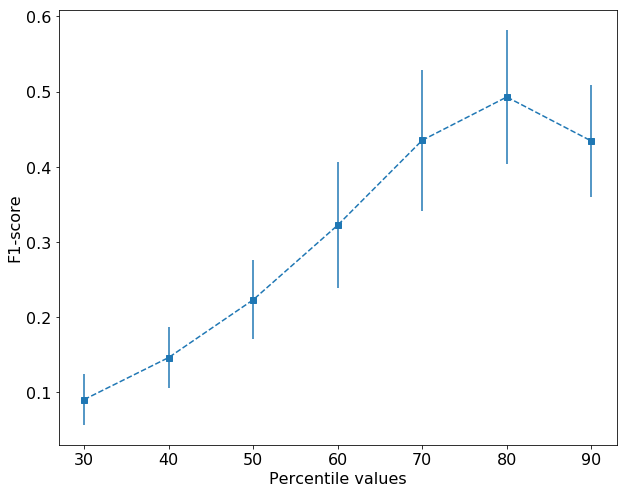

In [13]:
fig, ax = plt.subplots(figsize=(10,8),ncols = 1, nrows = 1)

ax.errorbar(np.arange(7),np.nanmean(res,axis=0),yerr=np.nanstd(res,axis=0),fmt='--', marker='s')
ax.set_xticklabels(labels =[0,30,40,50,60,70,80,90],fontsize=16)

ax.set_xlabel('Percentile values',fontsize=16)
ax.set_ylabel('F1-score',fontsize=16)
ax.tick_params(axis="y", labelsize=16)


In [4]:
dict_param['percentile']=80

# Save Dictionary values

In [14]:
set_dir='/ASTRA/set1/'

if not(os.path.exists(set_dir)):
    os.mkdir(set_dir)
    print('Created',set_dir)
    
with open(set_dir+'dict_dataset1.txt', "wb") as fp:   #Pickling
    pickle.dump(dict_param, fp)

In [15]:
dict_param

{'list': [0, 40, 80, 120, 160],
 'blocks': 15,
 'threads': 32,
 'BPM_ratio': 3,
 'bb': 96,
 'N_pix_st': 100,
 'astr_min': 80,
 'percentile': 80,
 'pad': 5,
 'astro_num': 4,
 'init_th_': 0.6,
 'decr_dim': 10,
 'decr_th': 25,
 'corr_int': False,
 'gpu_flag': True,
 'th1_p': 0.25,
 'th2_p': 0.1,
 'max_min': [345, 89]}